In [1]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘purrr’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: maps


A

In [2]:
nc <- nc_open("data/Zinser_SizeDist_calibrated-26-6.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:25*delta_v) 

In [3]:
df <- read.csv("data/Zinser_Figure2A.csv")
abundance <- rowMeans(df[,c(3,2)]) # mean of culture A and B
clean <- smooth.spline(time, abundance, df=15) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")


- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [4]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate

[1] "Division rate =  0.631 / day"


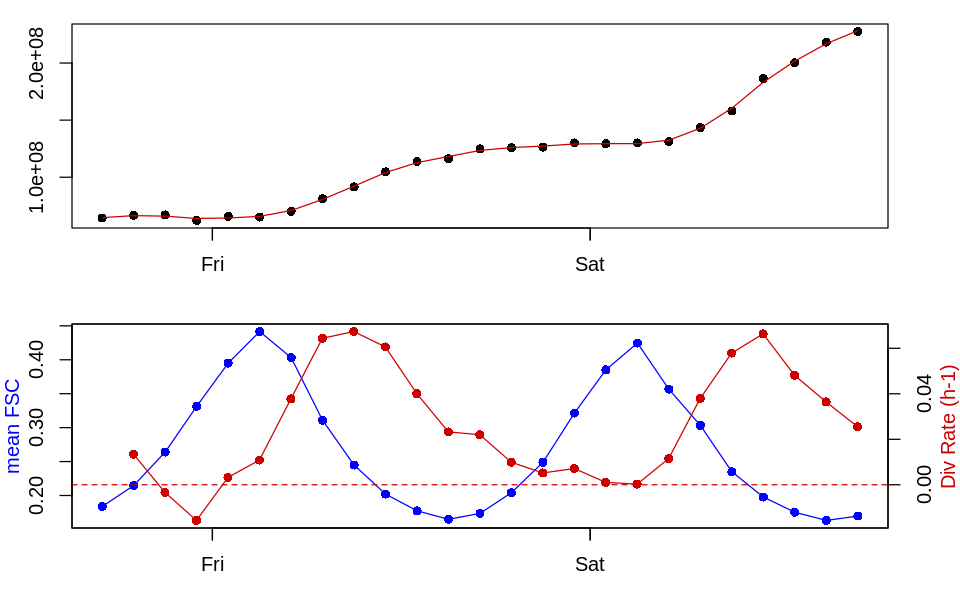

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5)

par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(time, abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(time, abundance, pch=16)
lines(clean,col="red3" )
plot(time, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1]-50,y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA, xlim=range(time))
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


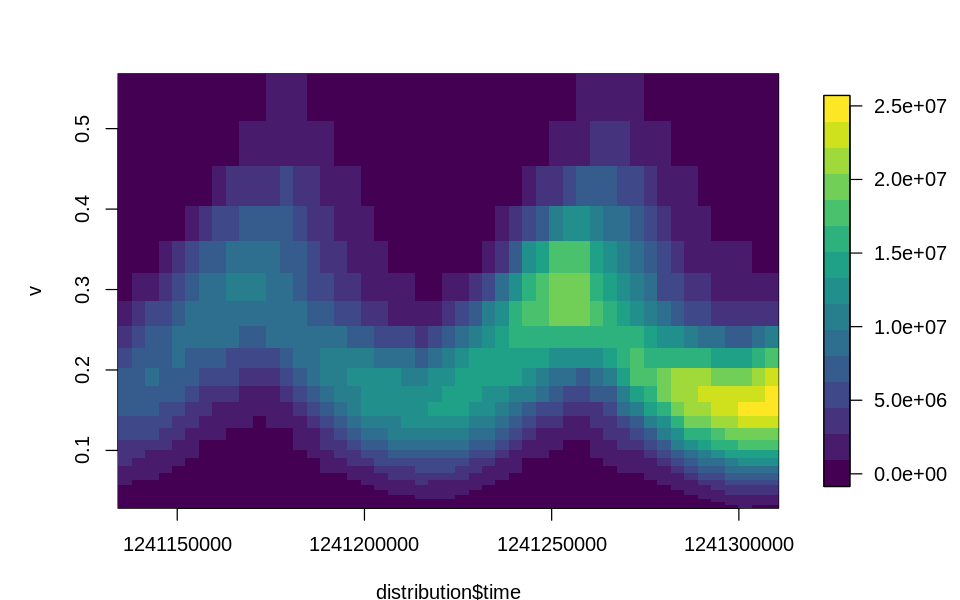

In [6]:
w_obs2 <- round(w_obs * abundance)
dist <- as.data.frame(w_obs2)
dist$time <- time

dist <- dist[,c(27,1:26)] # reorganize dataframe to be compatible with ssPopModel


resol.i <- 60 # in minutes
# Extrapolate dat based on "resol"
DF <- NULL
for(i in 1:dim(dist)[2]){
     df <- approx(dist$time, dist[,i], xout=seq(min(time), max(time), by=60*resol.i))
     DF <- cbind(DF, df$y)
    }
colnames(DF) <- c("time", v)

write.csv(DF, "data/FSC_Array5_calibrated_1hr.csv", quote=F, row.names=F)

### select 1 day Size distribution
id <- c(1:25)   
distribution <- as.data.frame(DF[,])

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(distribution[,-c(1)]), col=viridis(15))

In [7]:
## PAR data
# resolution
resol <- 10 # in minutes

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution$time) & time  < max(distribution$time))

# Change temporal resolution 
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

# #plot
# options(repr.plot.width = 8, repr.plot.height = 8)
# plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
# points(ep$x,Edata, col=4, lwd=3)

In [8]:
source("scripts/functions_model.R")

output <- determine_opt_para(distribution,Edata,resol)

Loading required package: DEoptim

Loading required package: parallel


DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich




[1] "Optimizing gmax, dmax, b and E_star"
Iteration: 10 bestvalit: 90543.948850 bestmemit:    0.498043    0.094680    0.376692    0.908147
Iteration: 20 bestvalit: 90519.112462 bestmemit:    0.352626    0.086963    0.391107    0.675630
Iteration: 30 bestvalit: 90217.720155 bestmemit:    0.486237    0.075046    0.348538    0.895978
Iteration: 40 bestvalit: 90047.381419 bestmemit:    0.500272    0.075055    0.354052    0.994366
Iteration: 50 bestvalit: 89978.390156 bestmemit:    0.456046    0.072168    0.339241    0.899692
Iteration: 60 bestvalit: 89965.826522 bestmemit:    0.414192    0.071587    0.340171    0.805463
Iteration: 70 bestvalit: 89959.576513 bestmemit:    0.513368    0.072168    0.339241    0.997127
Iteration: 80 bestvalit: 89959.488137 bestmemit:    0.513747    0.072041    0.338552    0.997174
Iteration: 90 bestvalit: 89959.488137 bestmemit:    0.513747    0.072041    0.338552    0.997174
Iteration: 100 bestvalit: 89959.339701 bestmemit:    0.447006    0.072393    0.339434

In [9]:
params <- output$parameters
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) 
        b <- as.numeric(params[3]) 
        E_star <- as.numeric(params[4])

resnorm <- as.numeric(params[5])

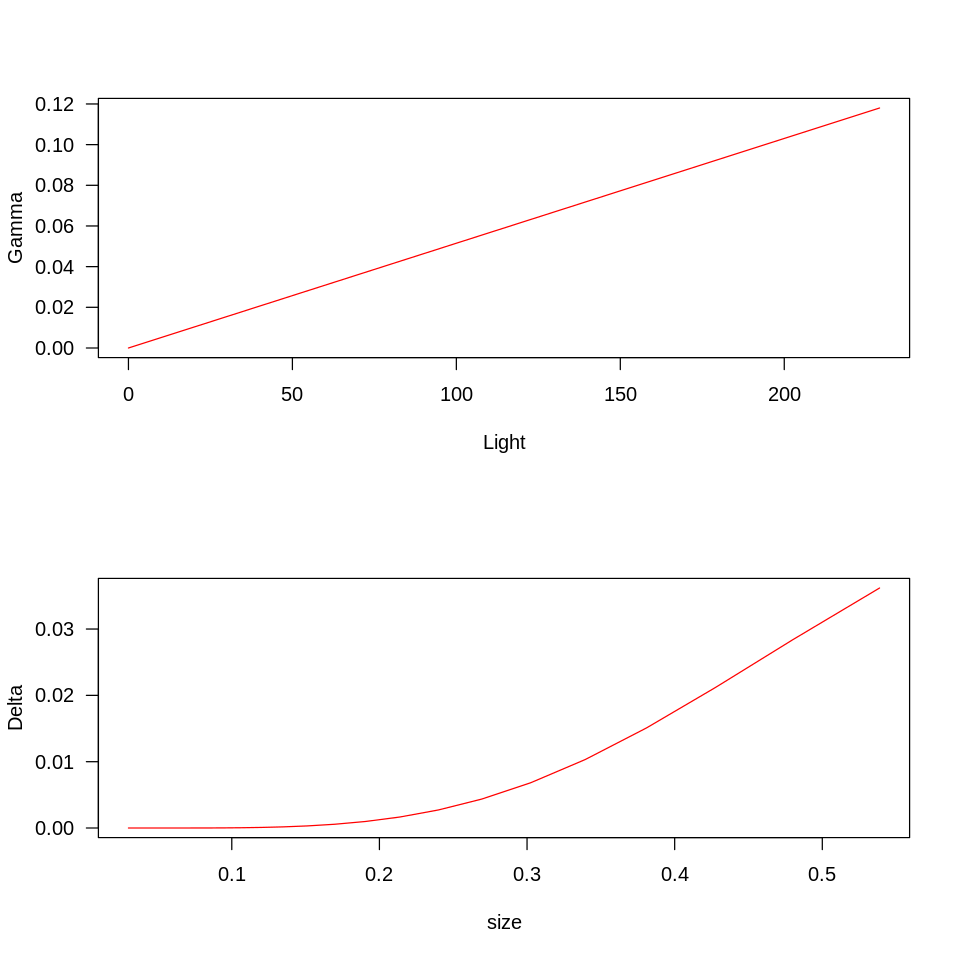

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,1))
plot(Edata, gamma_t(Edata, gmax, E_star), type='l', col='red', xlab="Light", ylab=paste("Gamma"), las=1)
plot(v, delta(v, dmax, b), type='l', col='red', xlab="size", ylab=paste("Delta"), las=1)    

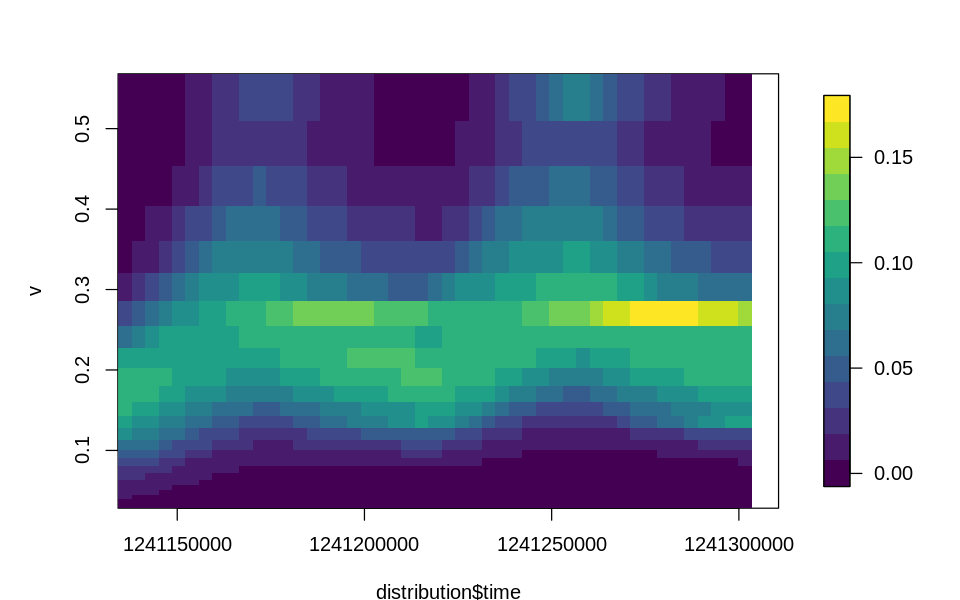

In [11]:
### plot size distribution
PSD <- output$PSD
Nproj <- as.matrix(PSD[,-c(1)])

### plot frequency distribution
s2 <- round(apply(Nproj, 1, function(x) sum(x,na.rm=T)))
Vproj <- as.matrix(Nproj/s2)

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=as.matrix(Vproj), col=viridis(15))

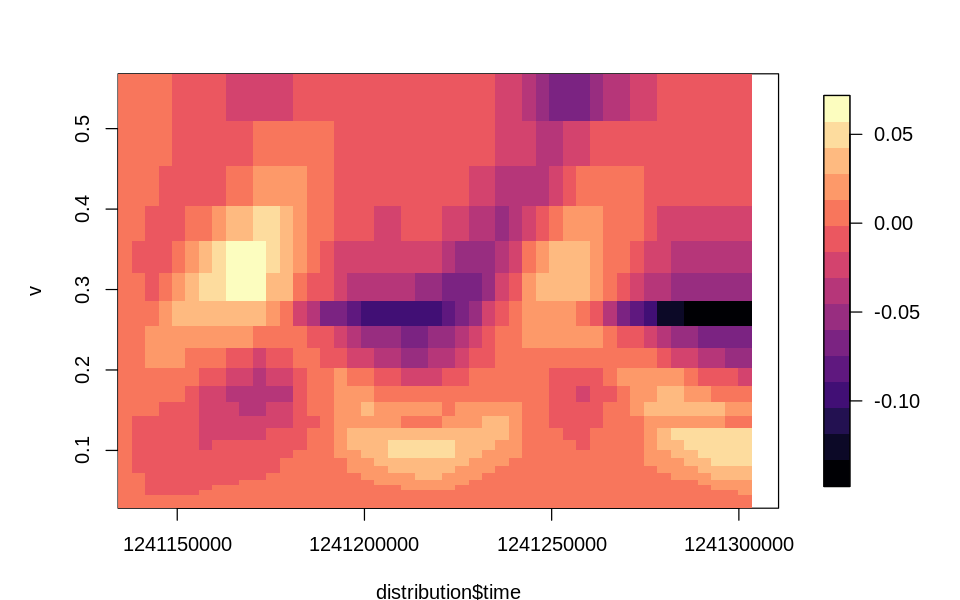

In [25]:
### plot difference Observed - Projected
s <- round(apply(distribution[,-c(1)], 1, function(x) sum(x,na.rm=T)))                   
z <- as.matrix(distribution[,-c(1)]/s) - Vproj

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution$time,y=v,z=z, col=viridis(15, option="A"))

[1] "daily growth rate= 0.69"


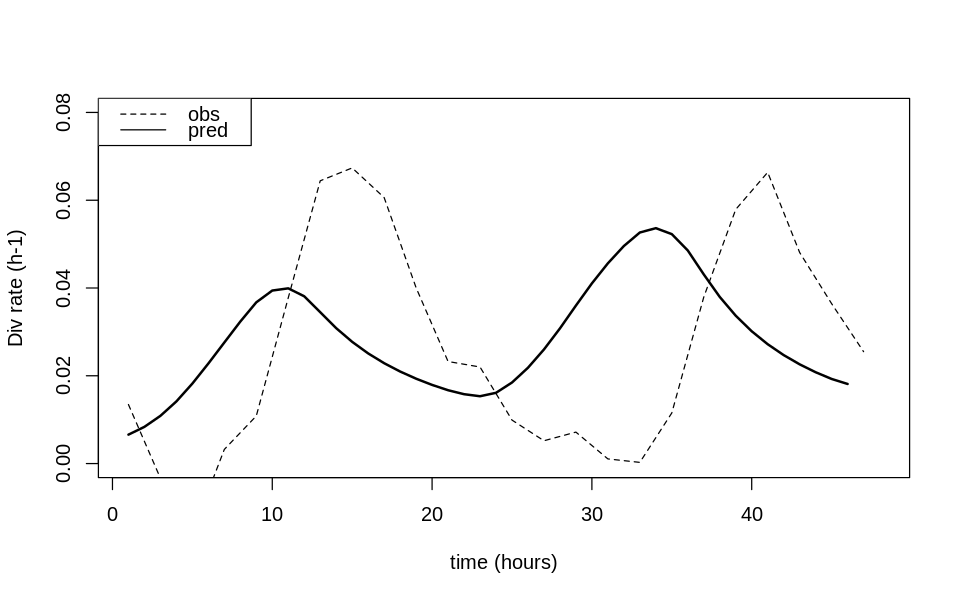

In [13]:
###############################
## Division rate calculation ##
###############################
mu_N <- diff(log(rowSums(PSD[,-c(1)], na.rm=T))) / as.numeric(diff(PSD$time)/3600)
d.mu_N <- 24*mean(mu_N[1:45], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))

#plot
options(repr.plot.width = 8, repr.plot.height = 5)
plot(mu_N,type='l', ylim=c(0,0.08), xlab='time (hours)', ylab="Div rate (h-1)", lwd=2)
lines(seq(1,48,2), y=dr, lty=2)
legend("topleft",c("obs","pred"), lty=c(2,1))

In [174]:
330 * ((3/4*pi)*(0.55/2)^3)^0.861

[1] 24.59145

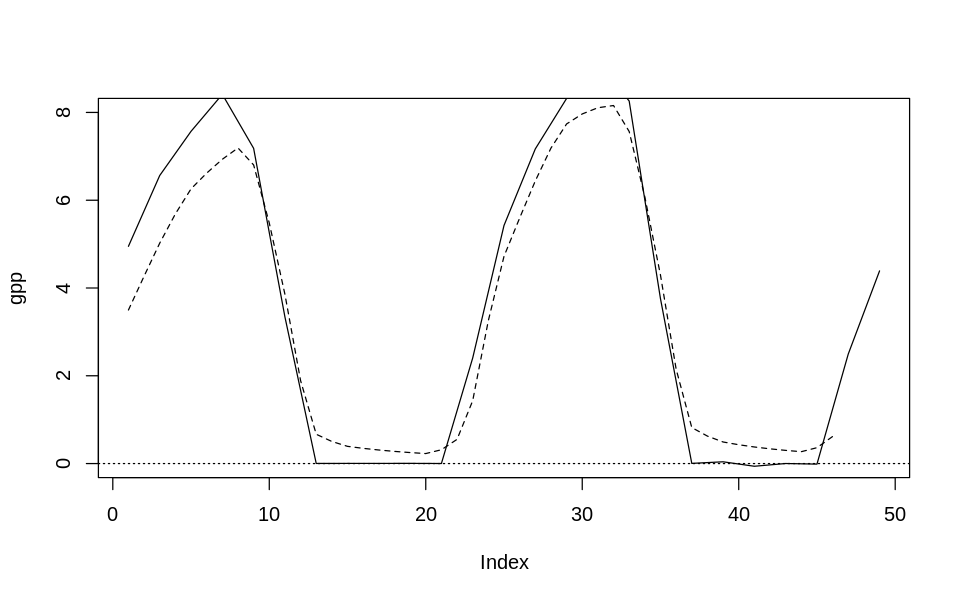

In [15]:
#############################
## Growth rate calculation ##
#############################
#c <- 261 * (1*v)^0.861 # Menden-Deuer # NOTE we can multiply Volume by 1.5 to make our estimates of light-scatter based volume fit Carbon measurements
c <- 330 * (1*v)^0.861 # Casey (mean diam 0.55 micron -> 25 fgC per cell)

# 1 hr data interpolation, for compatibility with 1-hr model output
gpp <- approx(df2[,3], n=49)$y 
count <- approx(clean, n=49)$y

#  Net growth rate
# biom1 <- diag(c) %*%  t(as.matrix(distribution[,-c(1)]))
# n.quotas <- colSums(biom1) / count # quotas
# g.quotas <- gpp * count

# plot(colSums(biom1))
# lines(cumsum(g.quotas))

# Proj Net growth rate
biom <-  diag(c) %*%  t(Nproj) 
gr <- diff(colSums(biom)) / rowSums(Nproj)[-49]

options(repr.plot.width = 8, repr.plot.height = 5)
plot( gpp, type="l", ylim=c(0,8))
lines(gr, lty=2); abline(h=0, lty=3)


In [16]:
##################################
## Respiration rate calculation ##
##################################
# resp <- gpp-gr

# plot(seq(0,48,1), resp, type="l")


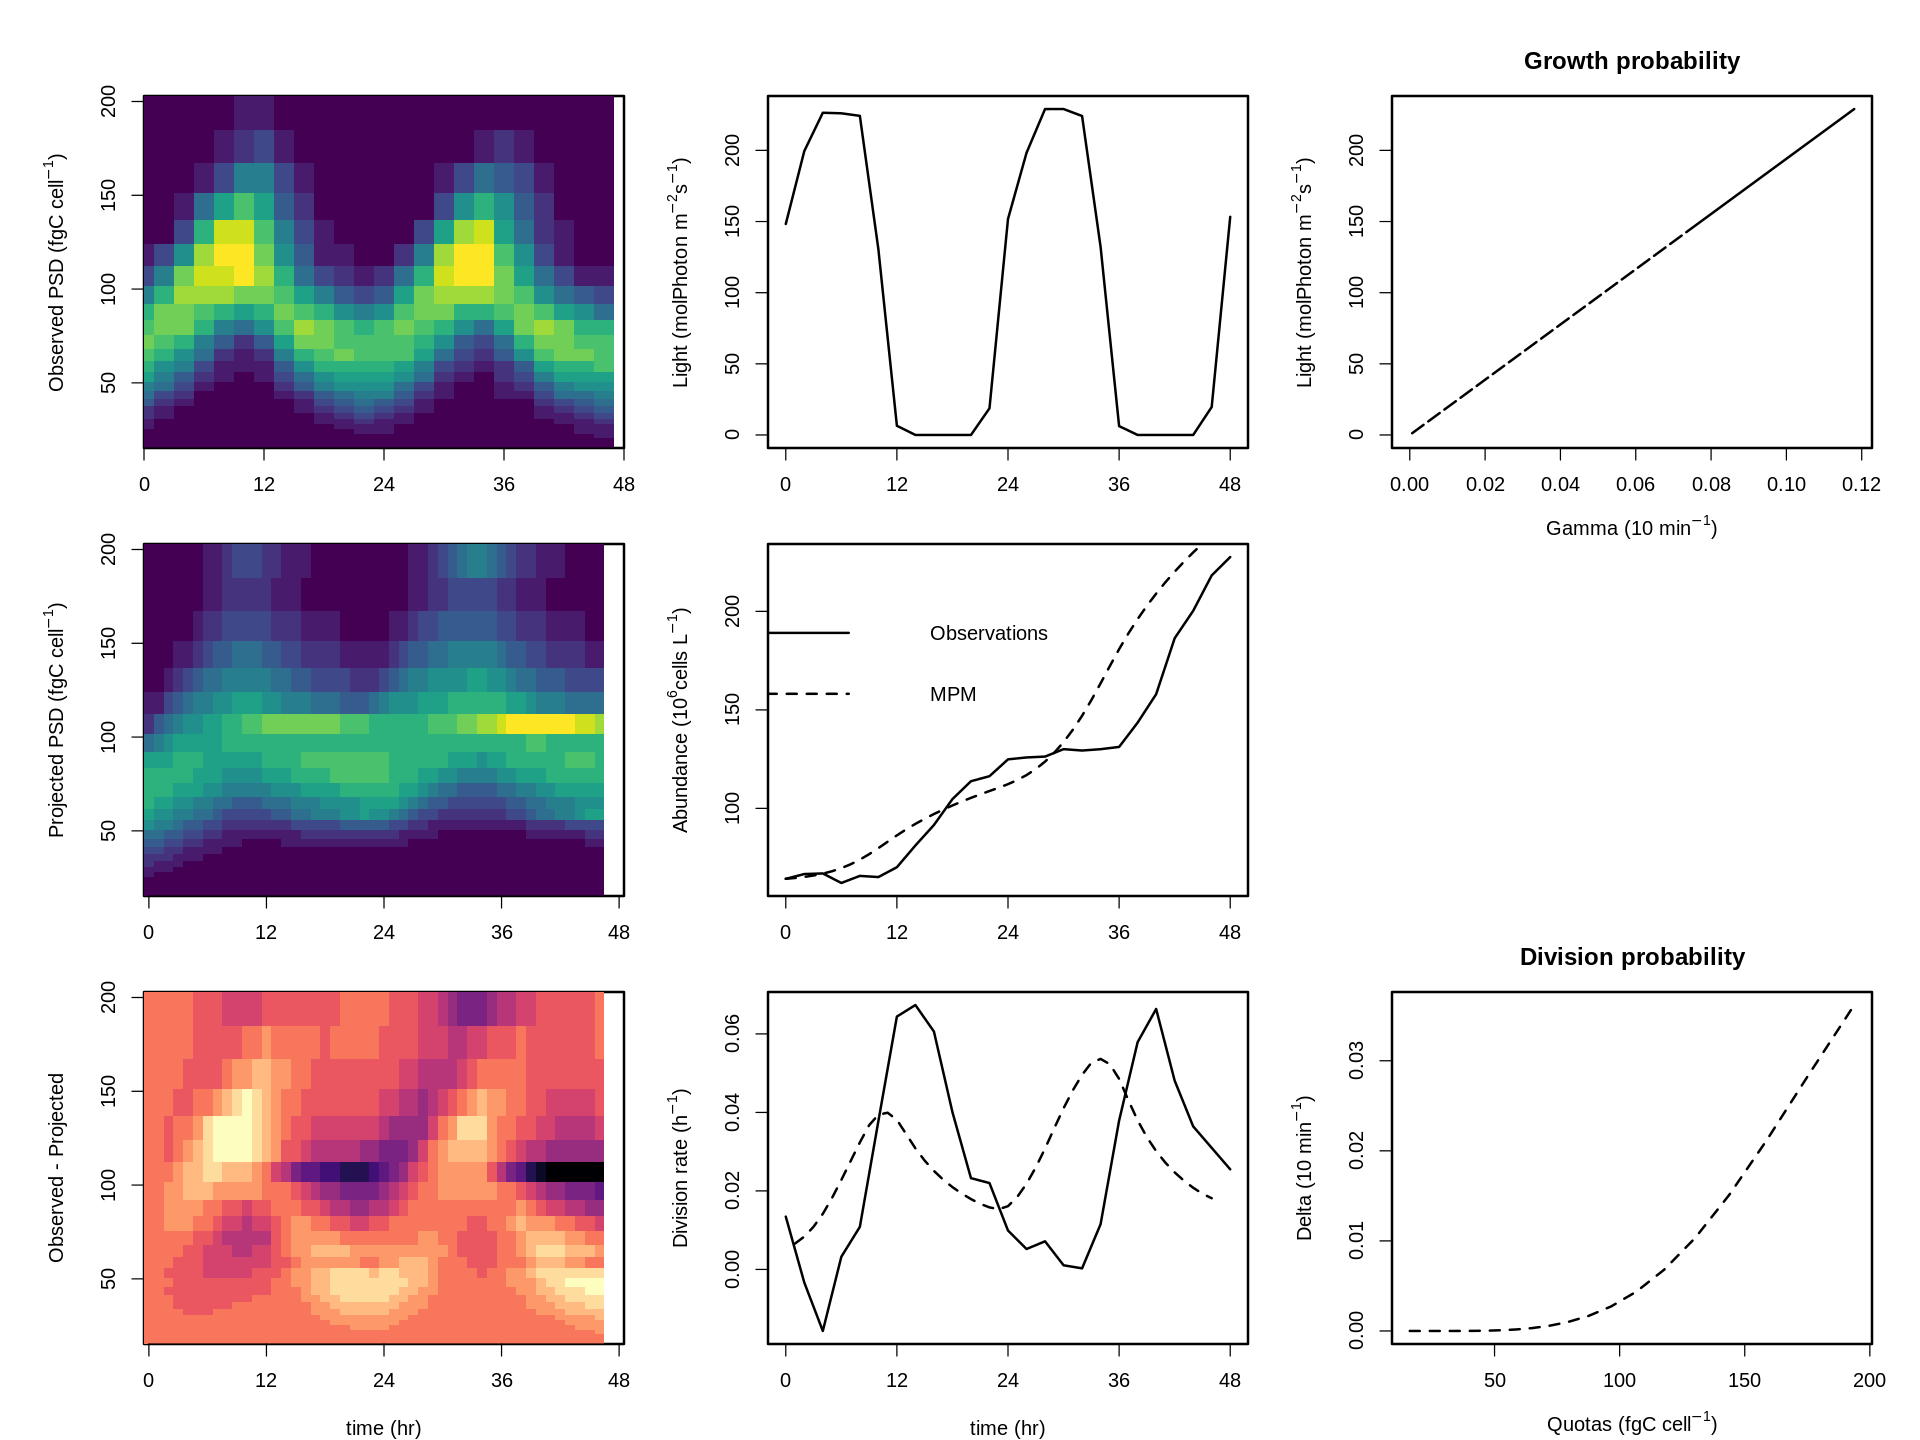

In [171]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 16, repr.plot.height = 12)
layout(matrix(c(1:6,7,0,8), 3, 3, byrow = F))

par(mar=c(1,5,3,1), oma=c(3,1,1,1), lwd=2, cex=1)
image(x=time[-25],y=c,w_obs[-25,],col=viridis(15), ylab=expression('Observed PSD (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
image(x=distribution$time,y=c,Vproj,col=viridis(15),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
index <- cut(unlist(list(z)),15)
image(x=distribution$time,y=c,z,col=viridis(15, option="A"),ylab=expression('Observed - Projected'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(time,PAR,type='l',xaxt='n', ylab=expression('Light (molPhoton m'^-2*'s'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(time, abundance/10^6, type='l', xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
legend(r[1]-70000, y=220, legend=c("Observations","MPM"), lty=c(1,2), bty="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab=expression('Division rate (h'^-1*')'))
lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(gamma_t(Edata, gmax, E_star), Edata, type='l', lty=2, xlab="Gamma", ylab=expression('Light (molPhoton m'^-2*'s'^-1*')'), main="Growth probability")
mtext(expression('Gamma (10 min'^-1*')'), 1, 3)
plot(c, delta(v, dmax, b), type='l', lty=2, xlab="size", ylab=expression('Delta (10 min'^-1*')'), , main="Division probability") 
mtext(expression('Quotas (fgC cell'^-1*')'), 1,3)

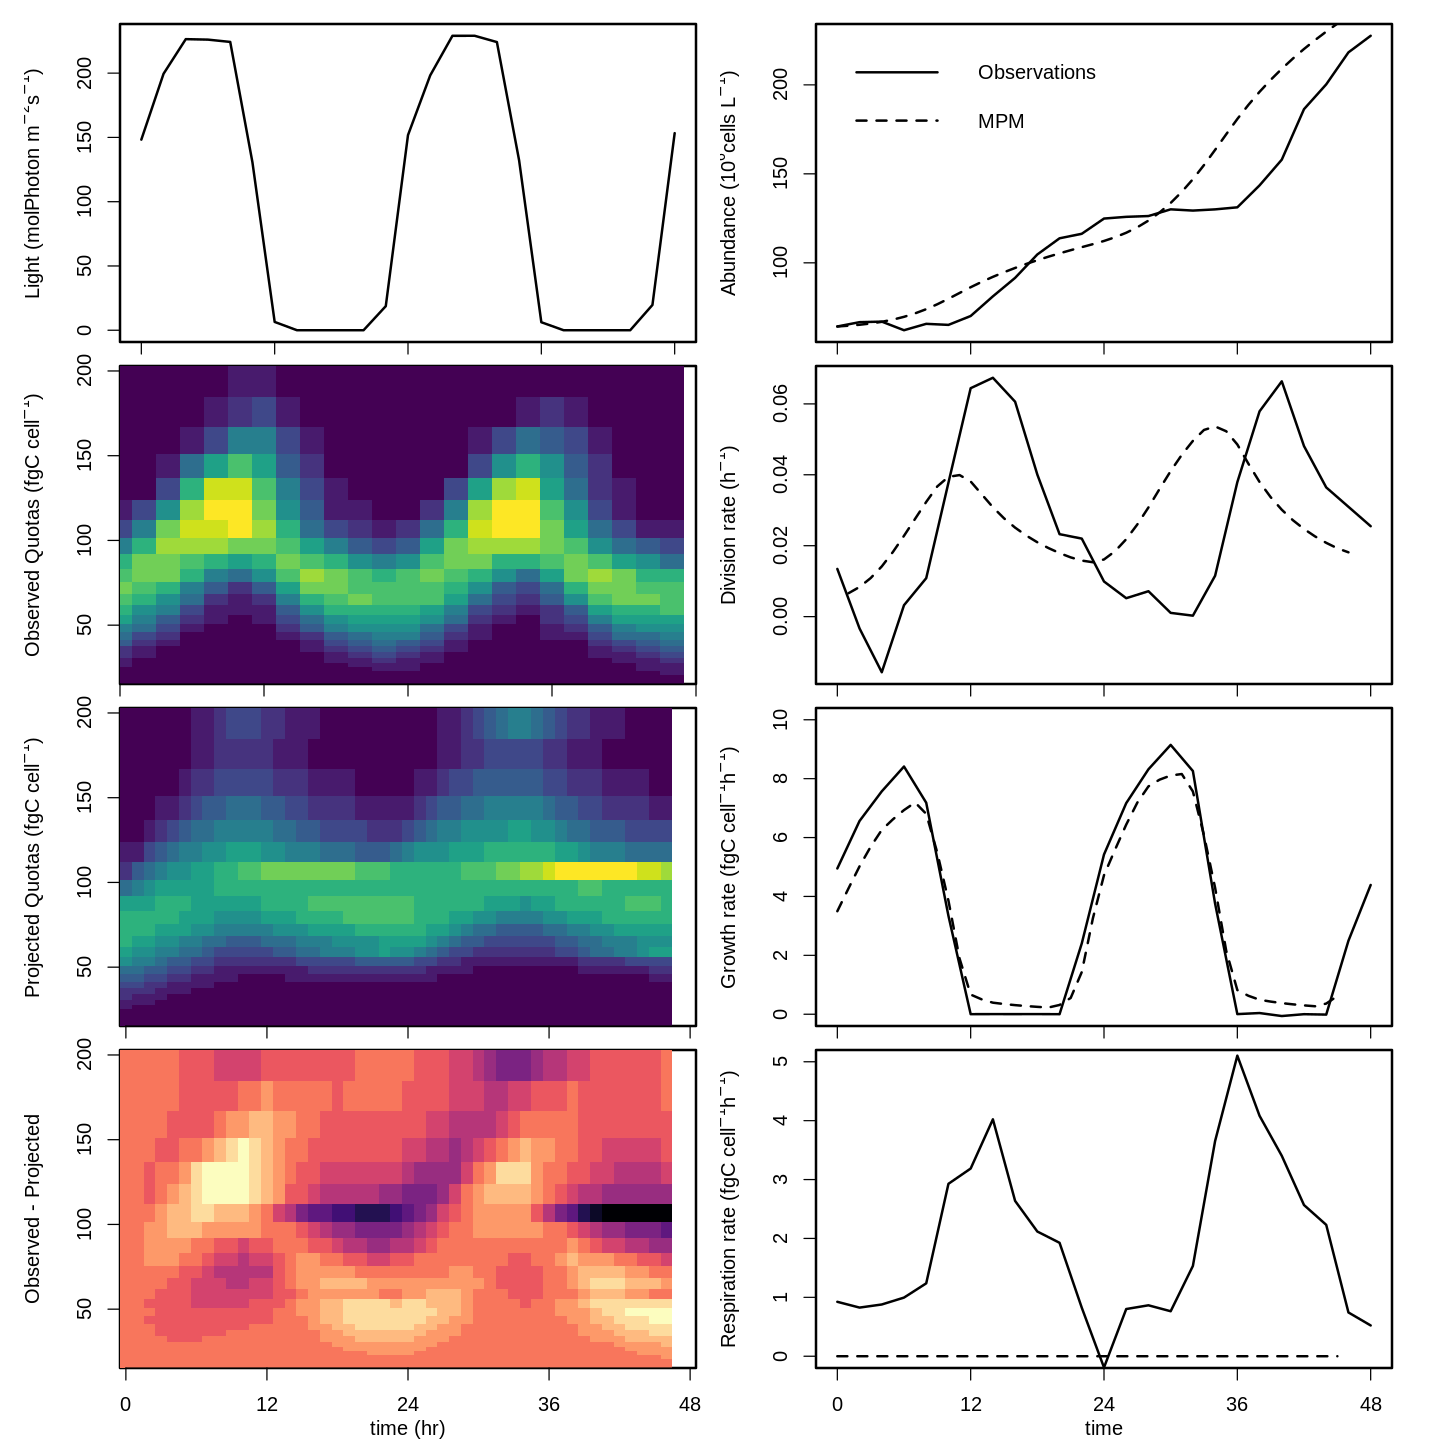

In [170]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution$time, origin="1970-01-01"))
options(repr.plot.width = 12, repr.plot.height = 12)
layout(matrix(c(1:8), 4, 2, byrow = FALSE))

par(mar=c(1,4,0,1), oma=c(2,1,1,1), lwd=2, cex=1)

plot(time,PAR,type='l',xaxt='n', ylab=expression('Light (molPhoton m'^-2*'s'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
image(x=time[-25],y=c,w_obs[-25,],col=viridis(15), ylab=expression('Observed Quotas (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
image(x=distribution$time,y=c,Vproj,col=viridis(15),ylab=expression('Projected Quotas (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
index <- cut(unlist(list(z)),15)
image(x=distribution$time,y=c,z,col=viridis(15, option="A"),ylab=expression('Observed - Projected'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 2)

plot(time, abundance/10^6, type='l', xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
lines(distribution$time, rowSums(Nproj)/10^6, lty=2)
legend("topleft", c("Observations","MPM"), lty=c(1,2), bty="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)

plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab=expression('Division rate (h'^-1*')'))
lines(x=distribution$time[-c(1)],y=mu_N, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
plot(time, df2[,3], type='l', xaxt="n", ylim=c(0,10), xlim=range(time),ylab=expression('Growth rate (fgC cell'^-1*'h'^-1*')'))
lines(x=distribution$time[-49],y=gr, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=NA)
plot(time, 0.5 * ( - df2[,3] + df2[,7]), xaxt="n", type='l', ylim=c(0,5), xlim=range(time), ylab=expression('Respiration rate (fgC cell'^-1*'h'^-1*')'))
lines(x=distribution$time[-49], y = gr *0, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time", 1, 2)